In [1]:
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
sns.set(font_scale=1.5)
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima_model import ARIMA

def to_date(value):
    return datetime.strptime(value, "%Y-%m-%d")

def loadDS():

  data = pd.read_csv("C:\\Users\\Herlisson\\OneDrive\\MECAI\\Aplicacoes de AM e Mineracao\\Projeto\\sandp500\\all_stocks_5yr.csv")
  data.head()
  data.dtypes

  data['date'] = data['date'].apply(to_date)
  data.set_index(['date'], inplace = True)
  data.head()

  return data

def prepareUT(data):

  data['low']   = 1
  data['open']  = 2
  data['close'] = 3
  data['high']  = 4

def myPlot(data, asset):

  fig, ax = plt.subplots(figsize = (20,8))
  ax.plot_date(data.loc[data['Name'] == asset].index , data.loc[data['Name'] == asset, 'open'],  'b-', linewidth=2)
  ax.plot_date(data.loc[data['Name'] == asset].index , data.loc[data['Name'] == asset, 'close'], 'g-', linewidth=2)
  #--- improvement: shading instead of points - DONE, IS OK?
  #ax.plot_date(data.loc[data['Name'] == asset].index,  data.loc[data['Name'] == asset, 'low'],   'g--', alpha=0.5, markersize=8) #Alterado
  #ax.plot_date(data.loc[data['Name'] == asset].index,  data.loc[data['Name'] == asset, 'high'],  'b--', alpha=0.5, markersize=8) #Alterado
  ax.fill_between(data.loc[data['Name'] == asset].index , data.loc[data['Name'] == asset, 'low'], data.loc[data['Name'] == asset, 'high'], alpha = 0.5)

  ax.set_ylim(data.loc[data.loc[data['Name'] == asset].index >= datetime.strptime('2017-01-01', "%Y-%m-%d")].min()[0:4].min() -3 , 
              data.loc[data.loc[data['Name'] == asset].index >= datetime.strptime('2017-01-01', "%Y-%m-%d")].max()[0:4].max() +3 ) #Alterado
  
  ax.set_ylabel("US$", fontsize=15)
  ax.set_title("Cotação do ativo "+asset , fontsize=25)
  ax.xaxis.set_minor_locator(dates.MonthLocator())
  ax.xaxis.set_minor_formatter(dates.DateFormatter("%m"))
  ax.xaxis.set_major_locator(dates.YearLocator())
  ax.xaxis.set_major_formatter(dates.DateFormatter("%Y"))
  ax.set_xlim(datetime.strptime('2017-01-01', "%Y-%m-%d") ,
              datetime.strptime('2018-02-01', "%Y-%m-%d"))

  ax.legend(fontsize=15)
  fig.autofmt_xdate()
  plt.show()

# loads S&P500 dataset and converts dates to typed structures
print('Loading and preprocessing the S&P500 dataset')
data = loadDS()
print('\n\nDataset loaded!')
#prepareUT(data)

Loading and preprocessing the S&P500 dataset


Dataset loaded!


Select an asset (ENTER to finish): A


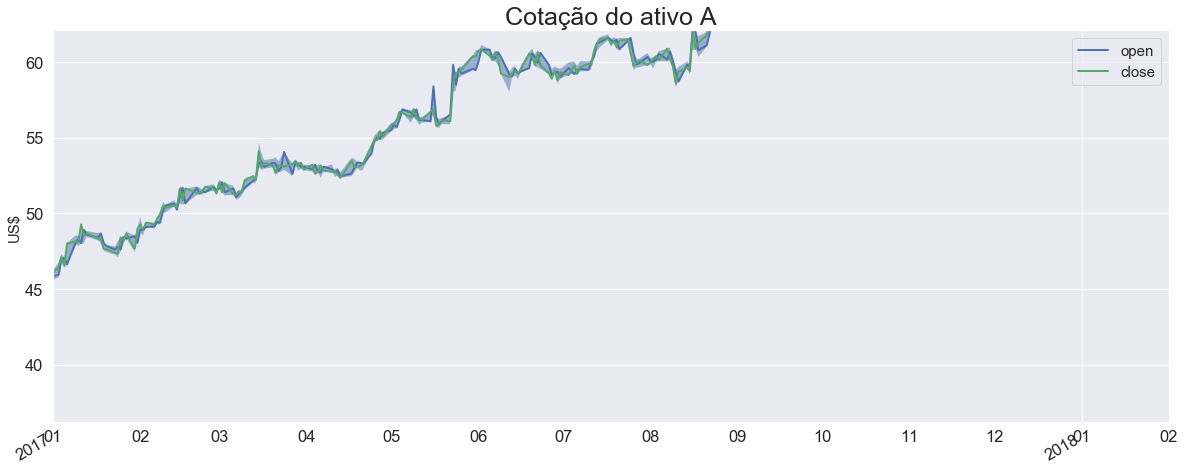

Asset		distance		close-open		high-low

A		Euclidiana		19.57		32.26

A		Manhattan		524.20		1029.90

A		cosine		 0.00		 0.00



In [ ]:
asset = input("Select an asset (ENTER to finish): ").upper()
while(len(asset) > 0):

  # plots the time series for the specified asset since Jan, closing values
  myPlot(data, asset)

  # computing similarity between pairs of time series

  distances = [('Euclidiana', sc.spatial.distance.euclidean),
               ('Manhattan',  sc.spatial.distance.cityblock),
               ('cosine',     sc.spatial.distance.cosine)]

  values = data.loc[ data['Name'] == asset,:]

  print('Asset\t\tdistance\t\tclose-open\t\thigh-low\n')
  for (distname, distf) in distances:	
    d1 = distf(values['open'], values['close'])
    d2 = distf(values['low'],  values['high'])
    print('{0}\t\t{1}\t\t{2:5.2f}\t\t{3:5.2f}\n'.format(asset, distname, d1, d2))

  asset = input("Select an asset (ENTER to finish): ").upper()

In [9]:
name = 'AAL'
data_prev = '2018-02-01'
passos = 1
intervalo = 30
serie = 'close'

#def media_movel(data, name, data_prev, passos=1,intervalo, serie):
indice = np.min( np.where( (data.index == data_prev) & (data.Name == name) ) )

if indice - intervalo < 0: #Very naive
  print('Insuficient data for the chosen interval !')

prev = data[ indice - intervalo : indice ]

for i in range(0,passos):
  media = prev[serie].iloc(axis=0)[0+i : intervalo + i].mean()
  idx = (to_date(data_prev) + timedelta(days= i)).strftime("%Y-%m-%d")
  prev = prev.append(pd.DataFrame({serie: media} , index = [idx] ))

#Measuring errors of prediction
pred = prev[serie].iloc[intervalo : intervalo + passos]
real = data[serie].iloc(axis=0)[indice:indice+passos]

mse = mean_squared_error(real , pred)
rmse = mse ** (1/2)

abserror = 100*(abs( (np.array(pred)-np.array(real) ) / np.array(pred) )).sum()
mape =(1/passos)*abserror


    #return prev, rmse, mape
print(prev)

if prev[serie].iloc[intervalo] - prev[serie].iloc[intervalo-1] >0:
    print("\nTendencia de subir!")
else:
    print("\nTendencia de cair! ")

#previsao, erro1, erro2 = mediamovel(data, 'AAL', '2018-02-01',1,20,'close')

                    Name      close     high      low   open      volume
2017-12-18 00:00:00  AAL  51.490000  51.6600  51.2500  51.25   3236066.0
2017-12-19 00:00:00  AAL  51.440000  51.8100  51.2800  51.60   3019807.0
2017-12-20 00:00:00  AAL  51.920000  52.1000  51.1700  51.57   5172839.0
2017-12-21 00:00:00  AAL  52.790000  53.4700  52.0700  52.16   7125891.0
2017-12-22 00:00:00  AAL  52.590000  52.8800  52.4200  52.72   2425104.0
2017-12-26 00:00:00  AAL  52.850000  53.2150  52.3300  52.35   2774316.0
2017-12-27 00:00:00  AAL  52.400000  52.8800  52.0600  52.80   2831434.0
2017-12-28 00:00:00  AAL  52.460000  52.6300  52.2200  52.45   1845331.0
2017-12-29 00:00:00  AAL  52.030000  52.8200  52.0100  52.42   2697096.0
2018-01-02 00:00:00  AAL  52.990000  53.1000  51.9000  52.33   4084712.0
2018-01-03 00:00:00  AAL  52.340000  52.8600  52.0550  52.86   5074850.0
2018-01-04 00:00:00  AAL  52.670000  54.4000  52.2650  52.48   3557059.0
2018-01-05 00:00:00  AAL  52.650000  52.8388  52.43

In [54]:
data['Date'] = data.index
print(data.dtypes)
data['Date'] = pd.to_datetime(data['Date'])
print(data.dtypes)
data.set_index = data['Date']
data.head()
data[data.Name == name].close.values

open             float64
high             float64
low              float64
close            float64
volume             int64
Name              object
Date      datetime64[ns]
dtype: object
open             float64
high             float64
low              float64
close            float64
volume             int64
Name              object
Date      datetime64[ns]
dtype: object


array([14.75, 14.46, 14.27, ..., 49.76, 51.18, 51.4 ])

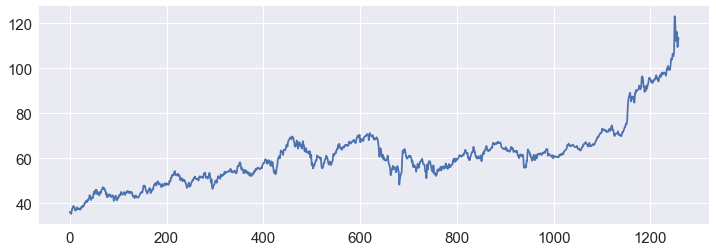

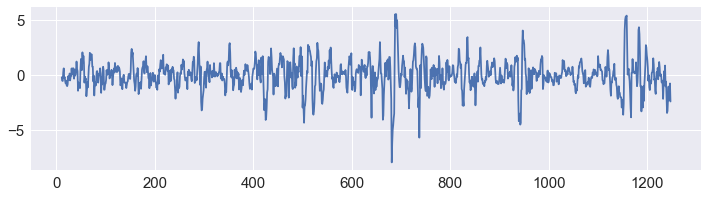

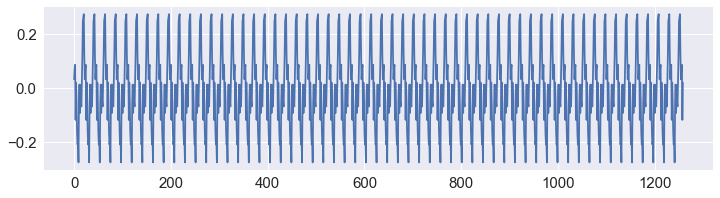

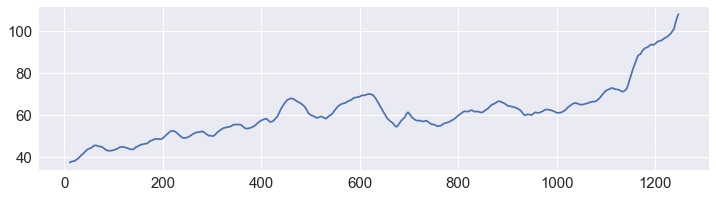

In [106]:
#Simple additive decomposition of the serie
name = 'ABBV'
#date = '2018-02-01'
steps_ahead = 1
n_train = 30
serie_name = 'close'

#X = data[data.Name == name].close
#X.reset_index(inplace = True)

from statsmodels.tsa.seasonal import seasonal_decompose

a=seasonal_decompose(data[data.Name == name].close.values, model="additive", freq=22)

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(data[data.Name == name].close.values)
plt.show()

fig, ax = plt.subplots(figsize=(12,3))
ax.plot(a.resid)
plt.show()


fig, ax = plt.subplots(figsize=(12,3))
ax.plot(a.seasonal)
plt.show()

fig, ax = plt.subplots(figsize=(12,3))
ax.plot(a.trend)
plt.show()



In [108]:
print(a.trend)
print(a.resid)
print(a.seasonal)
print(a.observed)

[ nan  nan  nan ...,  nan  nan  nan]
[ nan  nan  nan ...,  nan  nan  nan]
[ 0.03231927  0.06922268  0.08612203 ...,  0.08612203 -0.11834226
  0.01992885]
[  36.25   35.85   35.42 ...,  109.51  111.2   113.62]


Moving Average for YUM
MSE: 1.751, RMSE: 1.323, TU median: 1.000


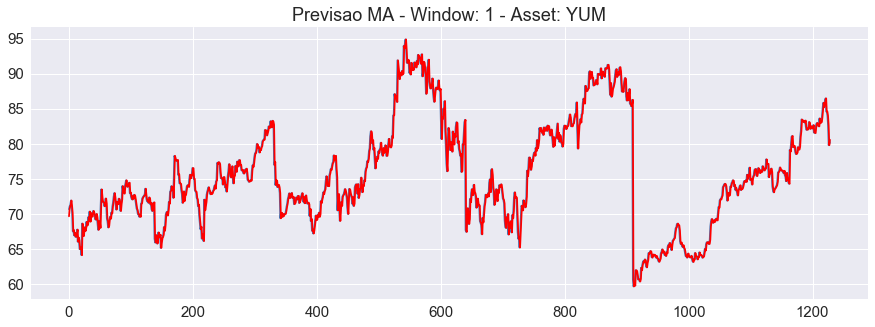

Moving Average for YUM
MSE: 2.157, RMSE: 1.469, TU median: 1.238


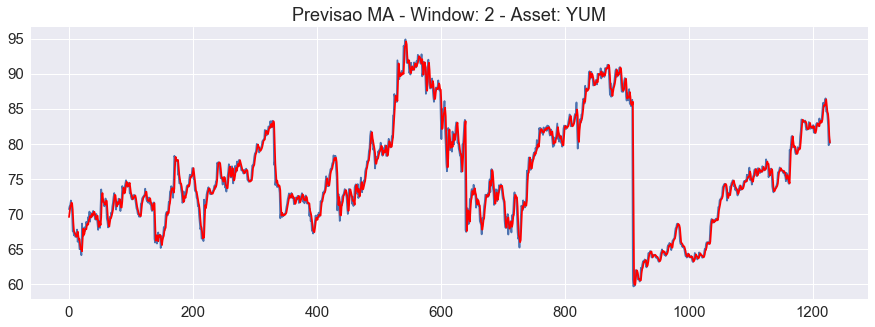

Moving Average for YUM
MSE: 2.617, RMSE: 1.618, TU median: 1.557


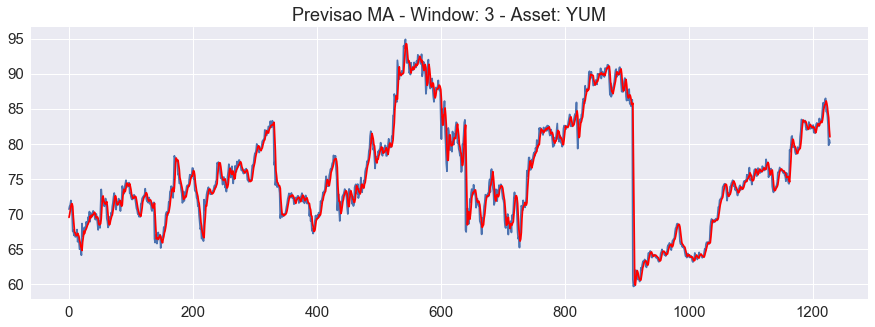

Moving Average for YUM
MSE: 3.086, RMSE: 1.757, TU median: 1.891


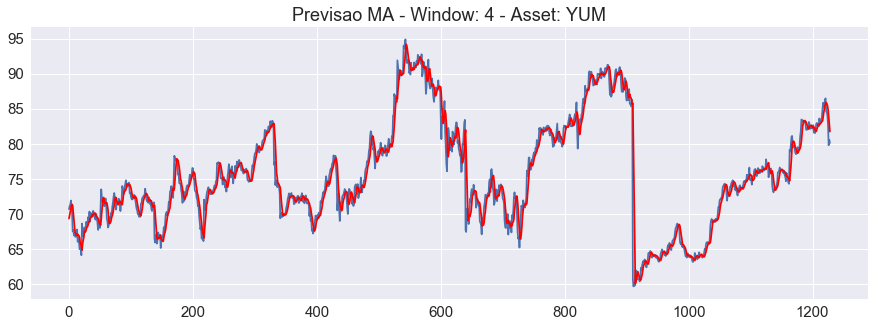

Moving Average for YUM
MSE: 3.538, RMSE: 1.881, TU median: 2.262


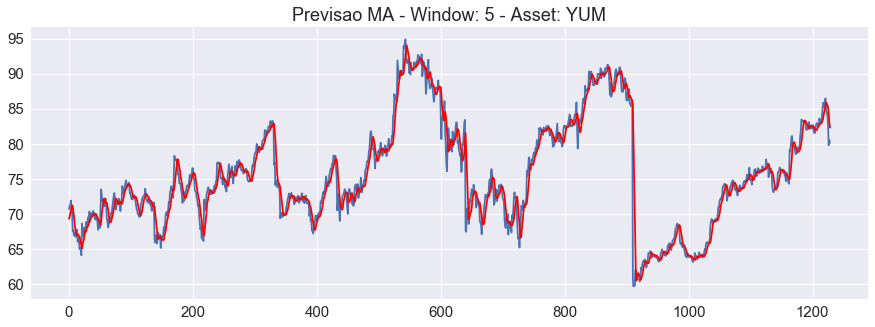

Moving Average for YUM
MSE: 3.984, RMSE: 1.996, TU median: 2.844


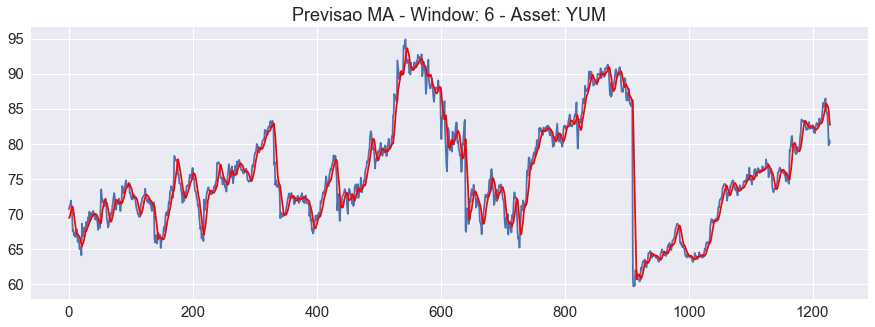

Moving Average for YUM
MSE: 4.424, RMSE: 2.103, TU median: 3.321


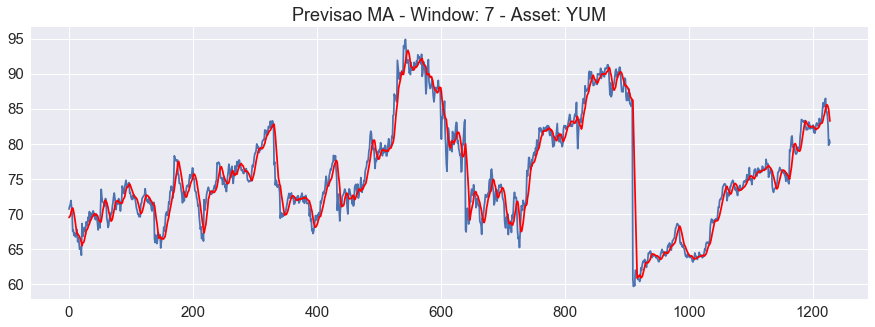

Moving Average for YUM
MSE: 4.862, RMSE: 2.205, TU median: 3.630


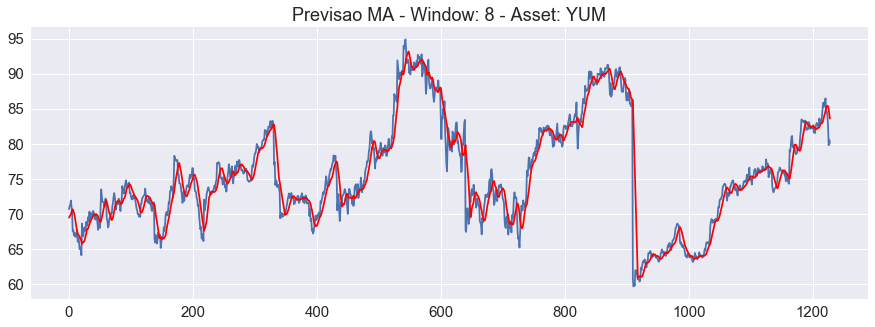

Moving Average for YUM
MSE: 5.303, RMSE: 2.303, TU median: 4.225


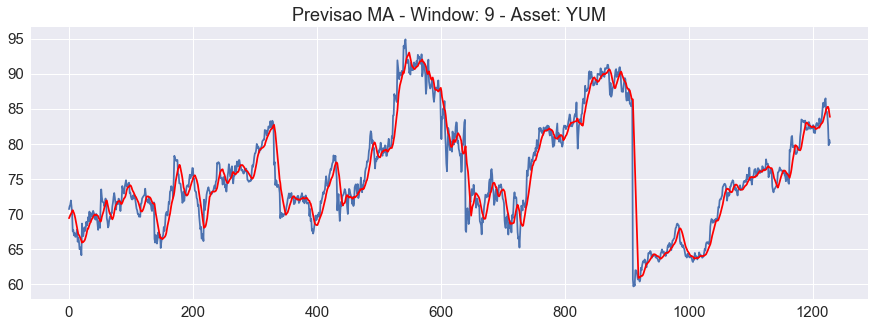

Moving Average for YUM
MSE: 5.736, RMSE: 2.395, TU median: 4.413


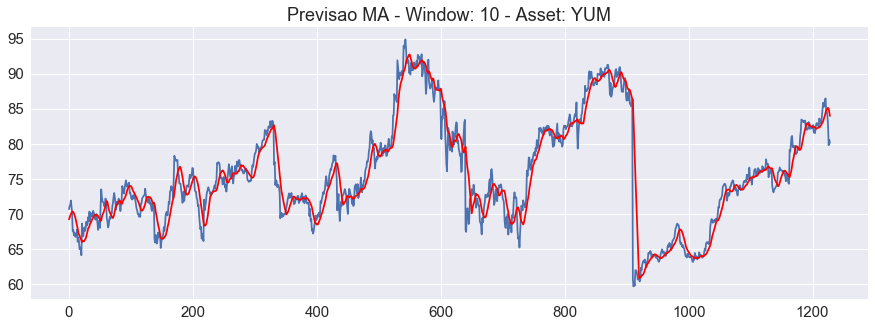

Moving Average for YUM
MSE: 6.168, RMSE: 2.484, TU median: 5.008


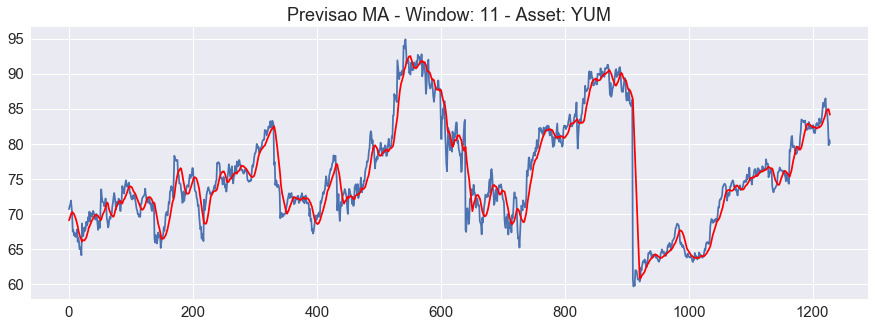

Moving Average for YUM
MSE: 6.612, RMSE: 2.571, TU median: 5.757


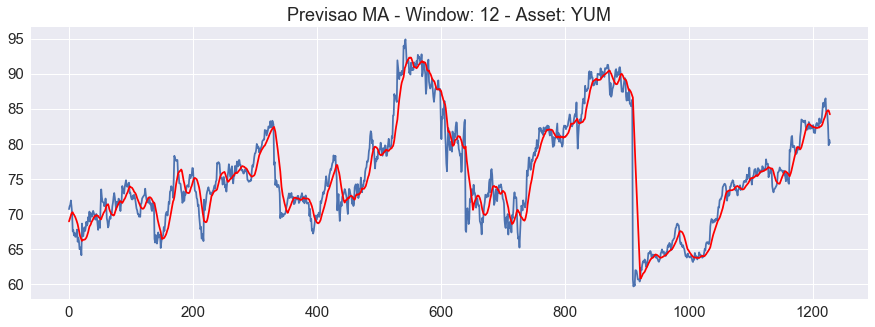

Moving Average for YUM
MSE: 7.061, RMSE: 2.657, TU median: 5.805


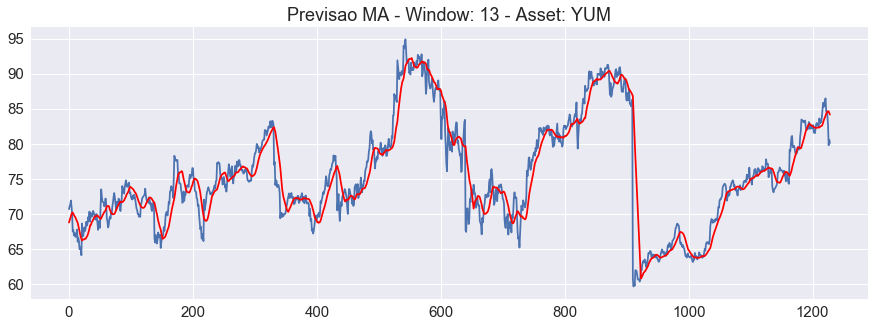

Moving Average for YUM
MSE: 7.513, RMSE: 2.741, TU median: 6.286


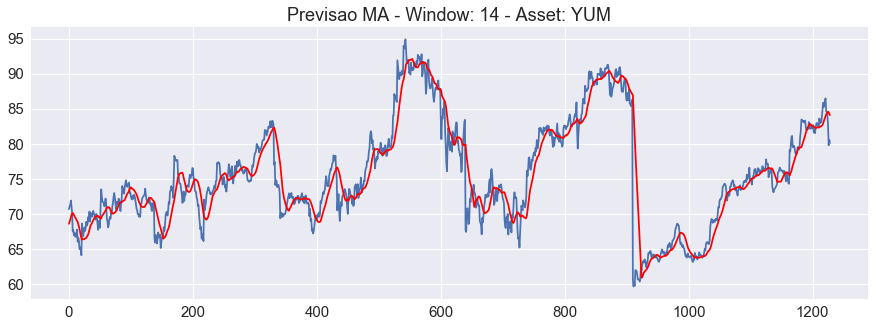

Moving Average for YUM
MSE: 7.972, RMSE: 2.824, TU median: 6.558


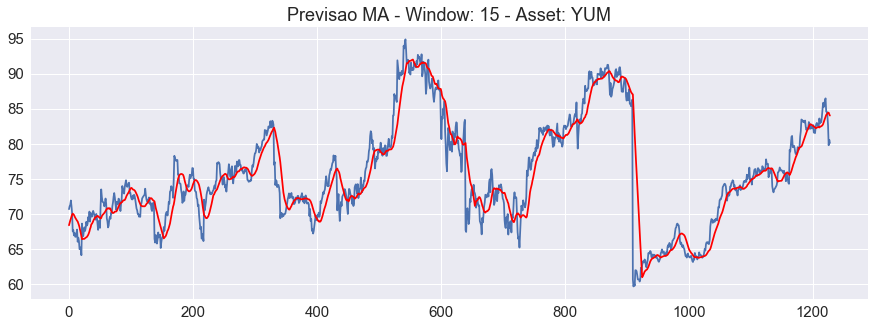

Moving Average for YUM
MSE: 8.420, RMSE: 2.902, TU median: 6.958


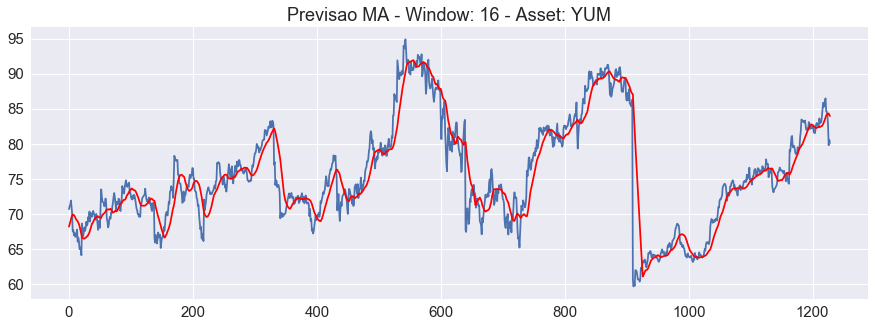

Moving Average for YUM
MSE: 8.858, RMSE: 2.976, TU median: 7.276


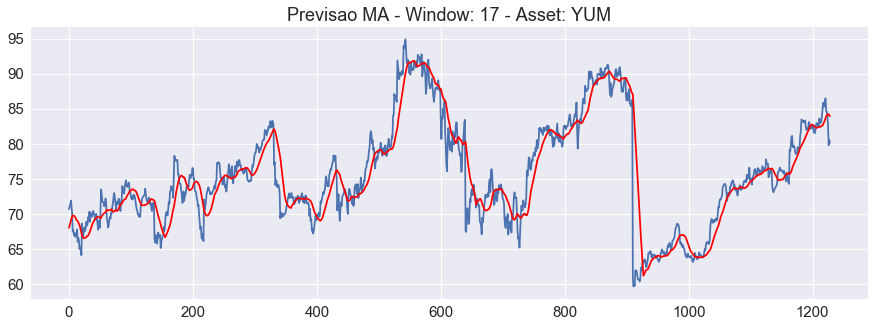

Moving Average for YUM
MSE: 9.290, RMSE: 3.048, TU median: 7.573


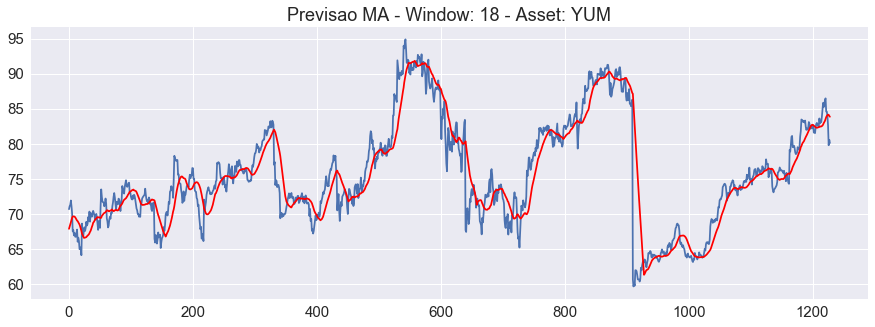

Moving Average for YUM
MSE: 9.718, RMSE: 3.117, TU median: 7.884


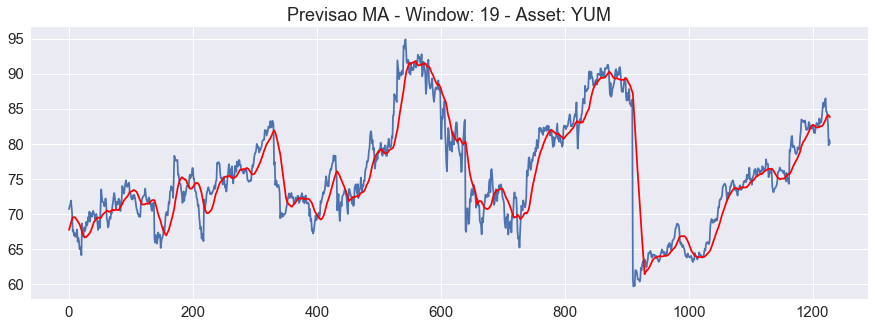

In [127]:
asset_name = 'YUM'
#date = '2018-02-01'
steps_ahead = 1
n_train = 30
serie_name = 'close'
#window = 5

#Simple moving average prediction
def simple_ma(serie, window, steps_ahead):
    serie_length = len(serie)
    for i in range(steps_ahead):
        serie = np.append(serie, np.mean( serie[len(serie) - window :]) )
        return serie[serie_length : serie_length + steps_ahead]

def cv_movingwindow_ma(asset_name, serie_name , n_train,window, steps_ahead=1):
    X = data[serie_name][data.Name == asset_name].values
    predictions = np.array([])
    test = np.array([])

    #Need changes for steps_ahead>1
    for i , j in zip( range( n_train, len(X) ) , range(0 , len(X) - n_train ) ):
        train, test = X[0:i] , np.append(test, X[i : i+1]) 
        yhat = simple_ma(train, window, steps_ahead)
        #print('yhat=%.3f' %yhat)
        predictions = np.append(predictions,yhat)
        #print('predicted = %.2f, expected = %.2f'  %(yhat,test[j]))
    return predictions, test

#Assessing down, stable or up given a treshold
def serie_trend(serie , tresh = 1):
    variation = (serie[1:] / serie[:-1] -1) * 100

    return pd.Series(variation).apply( lambda x: 'Down' if x < -tresh else('Up' if x > tresh else 'Stable')  )
#testing several window size
for window in range(1,20):
    predictions, test = cv_movingwindow_ma(asset_name, serie_name, n_train,window)

    mse = mean_squared_error(test , predictions)
    rmse = mse ** (1/2) 

    #Calculating U of Theil coeficient
    #np.finfo(float).eps
    tu= np.zeros(len(predictions))
    #print(tu)
    for i in range(1,len(predictions)):
        #tu[i] = ((predictions[i] - test[i]) ** 2) /((test[i] - test[i-1]) ** 2)
        a = (predictions[i] - test[i]) ** 2
        b = (test[i] - test[i-1]) ** 2
        if (a == 0): 
            a += 0.01
        if (b == 0): 
            b += 0.01
        tu[i] = a / b
        #print('i:%d a: %.5f b: %.5f' % (i,a,b) )
    #print(tu.mean())
    print("Moving Average for "+asset_name+"\nMSE: %.3f, RMSE: %.3f, TU median: %.3f" %(mse,rmse,np.median(tu)))

    #Plotting forecast
    plt.figure(figsize=[15,5])    
    plt.plot(test)
    plt.plot(predictions, color='red')
    #plt.xlim([1000,1250])
    plt.title("Previsao MA - Window: " + str(window)+ " - Asset: " + asset_name)
    plt.show()


Moving Average for AAL
MSE: 0.869, RMSE: 0.932, TU median: 1.006


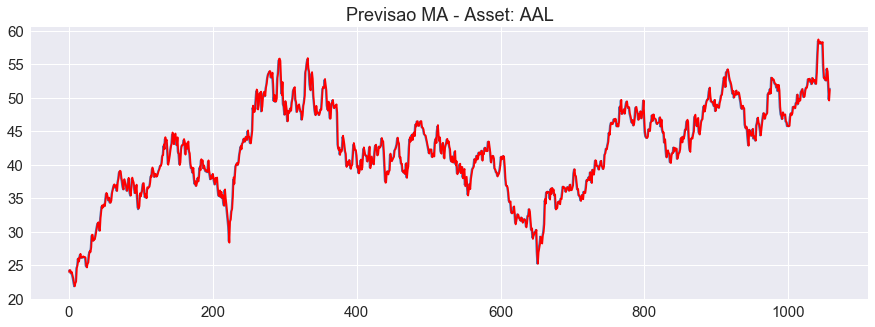

In [164]:
asset_name = 'AAL'
#date = '2018-02-01'
steps_ahead = 1
n_train = 200
serie_name = 'close'
window = 5
from statsmodels.tsa.arima_model import ARIMA

#Simple moving average prediction
def prev_arima(serie, max_values,p,q,d, steps_ahead):
    if len(serie)> max_values : 
        ini = len(serie) - max_values
    else:
        ini = 0
    model = ARIMA(serie[ini:], order=(p,q,d))
    model_fit = model.fit()
    output = model_fit.forecast()
    return output[0]
    
def cv_movingwindow(asset_name, serie_name , n_train, steps_ahead=1):
    X = data[serie_name][data.Name == asset_name].values
    predictions = np.array([])
    test = np.array([])

    #Need changes for steps_ahead>1
    for i , j in zip( range( n_train, len(X) ) , range(0 , len(X) - n_train ) ):
        train, test = X[0:i] , np.append(test, X[i : i+1]) 
        yhat = prev_arima(train, 300, 2,1,0, steps_ahead)
        #print('yhat=%.3f' %yhat)
        predictions = np.append(predictions,yhat)
        #print('predicted = %.2f, expected = %.2f'  %(yhat,test[j]))
    return predictions, test

#Assessing down, stable or up given a treshold
def serie_trend(serie , tresh = 1):
    variation = (serie[1:] / serie[:-1] -1) * 100

    return pd.Series(variation).apply( lambda x: 'Down' if x < -tresh else('Up' if x > tresh else 'Stable')  )

predictions, test = cv_movingwindow(asset_name, serie_name, n_train)

mse = mean_squared_error(test , predictions)
rmse = mse ** (1/2) 

#Calculating U of Theil coeficient
#np.finfo(float).eps
tu= np.zeros(len(predictions))
#print(tu)
for i in range(1,len(predictions)):
    #tu[i] = ((predictions[i] - test[i]) ** 2) /((test[i] - test[i-1]) ** 2)
    a = (predictions[i] - test[i]) ** 2
    b = (test[i] - test[i-1]) ** 2
    if (a == 0): 
        a += 0.01
    if (b == 0): 
        b += 0.01
    tu[i] = a / b
    #print('i:%d a: %.5f b: %.5f' % (i,a,b) )
#print(tu.mean())
print("Moving Average for "+asset_name+"\nMSE: %.3f, RMSE: %.3f, TU median: %.3f" %(mse,rmse,np.median(tu)))

#Plotting forecast
plt.figure(figsize=[15,5])    
plt.plot(test)
plt.plot(predictions, color='red')
#plt.xlim([1000,1250])
plt.title("Previsao MA - Asset: " + asset_name)
plt.show()

In [175]:
#Plotting ROC curve to find the optimal treshold
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

def auroc(predictions, true, min_tresh, max_tresh, n, cm=1):
    roc_auc = np.array([])
    treshs = np.linspace(max_tresh , min_tresh , n)

    for i in range(n):
        y_pred = serie_trend(predictions, treshs[i])
        y_true = serie_trend(true, treshs[i])
        conf_matrix = pd.crosstab(y_pred,y_true,margins=True,rownames=['Actual'],colnames=['Predicted'])
        print('Treshold: %.3f%%' %treshs[i])
        
        if cm:
            print(conf_matrix)

        y_pred = label_binarize(y_pred, classes=['Down','Stable','Up'])
        y_true = label_binarize(y_true, classes=['Down','Stable','Up'])


        roc_auc = np.append(roc_auc, roc_auc_score(y_true,y_pred,average='micro'))
        print('Average AUC: %.3f\n' %roc_auc[i])
    return roc_auc, conf_matrix 

aurocs_values = auroc(predictions,X[n_train:],0,0.7,10)

Treshold: 0.700%
Predicted  Down  Stable   Up   All
Actual                            
Down          7      22   13    42
Stable      264     552  293  1109
Up           14      41   22    77
All         285     615  328  1228
Average AUC: 0.605

Treshold: 0.622%
Predicted  Down  Stable   Up   All
Actual                            
Down         16      24   22    62
Stable      265     494  305  1064
Up           28      48   26   102
All         309     566  353  1228
Average AUC: 0.577

Treshold: 0.544%
Predicted  Down  Stable   Up   All
Actual                            
Down         24      33   30    87
Stable      276     411  315  1002
Up           48      56   35   139
All         348     500  380  1228
Average AUC: 0.537

Treshold: 0.467%
Predicted  Down  Stable   Up   All
Actual                            
Down         28      40   44   112
Stable      280     344  318   942
Up           62      61   51   174
All         370     445  413  1228
Average AUC: 0.508

Treshold: 0.

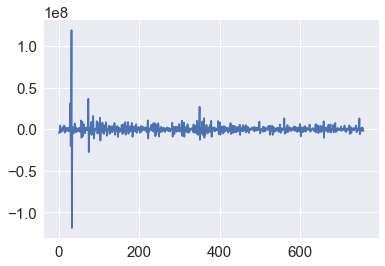

count    1.258000e+03
mean    -2.831215e+03
std      7.344148e+06
min     -1.187252e+08
25%     -2.152741e+06
50%     -5.463200e+04
75%      1.840941e+06
max      1.188695e+08
Name: volume, dtype: float64

In [119]:
plt.plot(data['volume'][data.Name == 'AAL'].diff().iloc[500:].values)
plt.show()
data['volume'][data.Name == 'AAL'].diff().describe()

In [166]:
#from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score

y_pred = serie_trend(predictions, treshs[0])
y_true = serie_trend(X[n_train:], treshs[0])
print('Treshold: %.3f%%' %treshs[0])
print(pd.crosstab(y_pred,y_true,margins=True,rownames=['Actual'],colnames=['Predicted']))

y_true = label_binarize(y_true, classes=['Down','Stable','Up'])
y_pred = label_binarize(y_pred, classes=['Down','Stable','Up'])

roc_auc_score(y_true,y_pred,average='micro')


Treshold: 1.000%
Predicted  Down  Stable   Up   All
Actual                            
Down          0       6    1     7
Stable      186     770  232  1188
Up            4      25    4    33
All         190     801  237  1228


0.7227198697068404

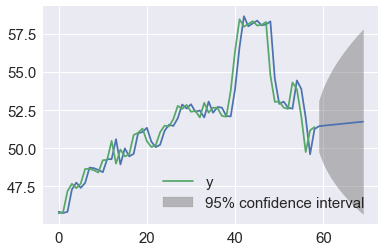

array([ 56.42,  58.47,  57.98,  58.16,  58.34,  58.06,  58.1 ,  58.29,
        54.79,  53.05,  53.07,  52.68,  52.59,  54.32,  53.88,  52.1 ,
        49.76,  51.18,  51.4 ])

In [159]:
#Testing ARIMA
serie = data['close'][data.Name == 'AAL'].values

model = ARIMA(serie, order=(1,1,1))
model_fit = model.fit()
output = model_fit.forecast(5)
#print(model_fit.summary())
model_fit.plot_predict(start=1200,end=len(serie)+10)
plt.show()
output[0]

serie[1240:]

In [103]:
data.Name.unique()

array(['AAL', 'AAPL', 'AAP', 'ABBV', 'ABC', 'ABT', 'ACN', 'ADBE', 'ADI',
       'ADM', 'ADP', 'ADSK', 'ADS', 'AEE', 'AEP', 'AES', 'AET', 'AFL',
       'AGN', 'AIG', 'AIV', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALK',
       'ALLE', 'ALL', 'ALXN', 'AMAT', 'AMD', 'AME', 'AMGN', 'AMG', 'AMP',
       'AMT', 'AMZN', 'ANDV', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'APC',
       'APD', 'APH', 'APTV', 'ARE', 'ARNC', 'ATVI', 'AVB', 'AVGO', 'AVY',
       'AWK', 'AXP', 'AYI', 'AZO', 'A', 'BAC', 'BAX', 'BA', 'BBT', 'BBY',
       'BDX', 'BEN', 'BF.B', 'BHF', 'BHGE', 'BIIB', 'BK', 'BLK', 'BLL',
       'BMY', 'BRK.B', 'BSX', 'BWA', 'BXP', 'CAG', 'CAH', 'CAT', 'CA',
       'CBG', 'CBOE', 'CBS', 'CB', 'CCI', 'CCL', 'CDNS', 'CELG', 'CERN',
       'CFG', 'CF', 'CHD', 'CHK', 'CHRW', 'CHTR', 'CINF', 'CI', 'CLX',
       'CL', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP',
       'COF', 'COG', 'COL', 'COO', 'COP', 'COST', 'COTY', 'CPB', 'CRM',
       'CSCO', 'CSRA', 'CSX', 'CTAS', 'CTL', 'CTSH', 'CTXS